In [66]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d

### Preprocessing

In [67]:
### Add derivative columns to df with water depth time series

def add_derv(df):
    df = df.copy()
    # calculates first derivative
    df['diff'] = df['Value'].diff(1).fillna(0) / df.index.to_series().diff(periods=-1).dt.seconds/60
    # smooths out sensor artifacts by takeing the mean over ~4 hours (10 min sampled data) or 6 hours (15 min)
    df['mean diff'] = df['diff'].rolling(window=24, min_periods=1, center=True).mean()
    # seperate falling limb from rising limb of hydrograph
    df_down = df[df['mean diff'] < -0.0000000001] 
    df_up = df[df['mean diff'] >= 0] 
    return df, df_down, df_up

In [68]:
### Read in USGS data (pulled from USGS Online Dataportal https://waterdata.usgs.gov)

hr = pd.read_csv("./data/USGS/huron_river.csv", sep =',')
indexes = []
for col, row in hr.iterrows():
    indexes.append(datetime.datetime.strptime(row['datetime'], "%Y-%m-%d %H:%M"))
hr.index= indexes
hr = hr.drop(['datetime'], axis=1)

mc = pd.read_csv("./data/USGS/mallets_creek.csv", sep =',')
indexes = []
for col, row in mc.iterrows():
    indexes.append(datetime.datetime.strptime(row['datetime'], "%Y-%m-%d %H:%M"))
mc.index= indexes
mc = mc.drop(['datetime'], axis=1)

hr, hr_down, hr_up = add_derv(hr)
mc, mc_down, mc_up = add_derv(mc)


In [69]:
hr_down

,Value,diff,mean diff
2019-01-01 00:00:00,13.04,0.000000e+00,-4.873294e-10
2019-01-01 00:15:00,13.02,-3.898635e-09,-2.998950e-10
2019-01-01 01:15:00,13.04,0.000000e+00,-1.146657e-10
2019-01-01 01:30:00,13.05,1.949318e-09,-4.331817e-10
2019-01-01 01:45:00,13.05,0.000000e+00,-5.129784e-10
...,...,...,...
2021-06-01 18:30:00,12.18,0.000000e+00,-2.436647e-10
2021-06-01 18:45:00,12.18,0.000000e+00,-2.436647e-10
2021-06-01 19:00:00,12.18,0.000000e+00,-1.624431e-10
2021-06-01 19:15:00,12.18,0.000000e+00,-1.624431e-10


In [146]:
### Read in open-storm data

site1 = pd.read_csv("./data/open_storm/bridge_clean.csv", sep =',')
# site1
indexes = []
for col, row in site1.iterrows():
    indexes.append(datetime.datetime.strptime(row['Unnamed: 0'], "%Y-%m-%d %H:%M:%S+00:00"))
site1.index= indexes
site1 = site1.drop(['Unnamed: 0'], axis=1)

site2 = pd.read_csv("./data/open_storm/bridge_error1.csv", sep =',')
indexes = []
for col, row in site2.iterrows():
    indexes.append(datetime.datetime.strptime(row['Unnamed: 0'], "%Y-%m-%d %H:%M:%S+00:00"))
site2.index= indexes
site2 = site2.drop(['Unnamed: 0'], axis=1)

site3 = pd.read_csv("./data/open_storm/double_obst.csv", sep =',')
indexes = []
for col, row in site3.iterrows():
    indexes.append(datetime.datetime.strptime(row['Unnamed: 0'], "%Y-%m-%d %H:%M:%S+00:00"))
site3.index= indexes
site3 = site3.drop(['Unnamed: 0'], axis=1)

site4 = pd.read_csv("./data/open_storm/plant_error1.csv", sep =',')
indexes = []
for col, row in site4.iterrows():
    indexes.append(datetime.datetime.strptime(row['Unnamed: 0'], "%Y-%m-%d %H:%M:%S+00:00"))
site4.index= indexes
site4 = site4.drop(['Unnamed: 0'], axis=1)

site5 = pd.read_csv("./data/open_storm/small_obst.csv", sep =',')
indexes = []
for col, row in site5.iterrows():
    indexes.append(datetime.datetime.strptime(row['Unnamed: 0'], "%Y-%m-%d %H:%M:%S+00:00"))
site5.index= indexes
site5 = site5.drop(['Unnamed: 0'], axis=1)

Note: the USGS csv's include the complete water level dataset, however the open-storm data only contains water level data for portions of the hydrograph where water level is decreasing.

When calculating the phase portrait, we only consider the decreasing water level portion of the hydrograph. The rate of water level rise depends on the intensity and spatial distribution of the storm. The variability added by these parameters makes if difficult to pick out site-specific trends, and therefore more difficult to idenfity noise. The rate of water descent depends primarily on site geometry, so by restricting our focus to this section of the hydrograph, we are indireclty observing site behavior that is (mostly) constant over long periods of time. 

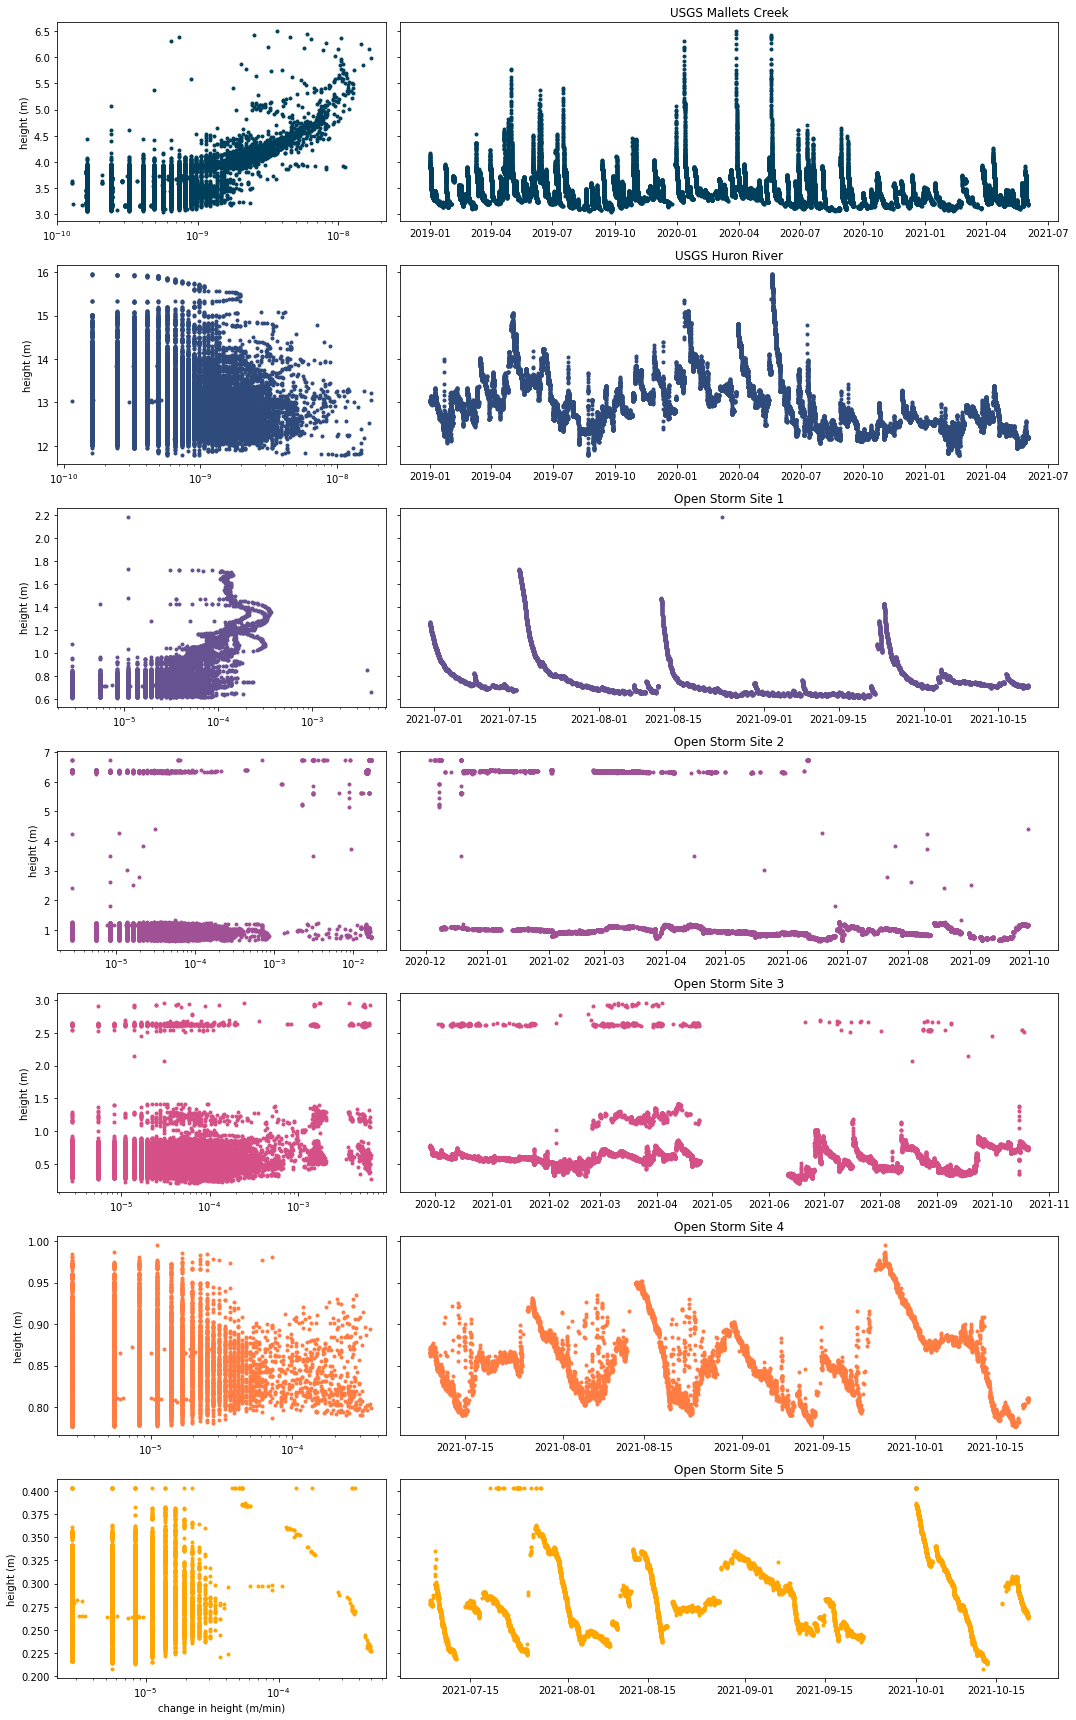

In [73]:
fig, ax = plt.subplots(ncols=2, nrows=7, figsize = (15, 24), sharey='row', gridspec_kw={'width_ratios': [1, 2]})
ax[0,0].scatter(-1*mc_down['mean diff'], mc_down['Value'], marker='.',color='#003f5c')
ax[0,0].set_xscale('log')
ax[0,1].scatter(mc_down.index, mc_down['Value'], marker = '.', color='#003f5c')
ax[0,0].set_ylabel('height (m)')
ax[0,1].set_title("USGS Mallets Creek")

ax[1,0].scatter(-1*hr_down['mean diff'], hr_down['Value'], marker='.',color='#2f4b7c')
ax[1,0].set_xscale('log')
ax[1,1].scatter(hr_down.index, hr_down['Value'], marker = '.', color='#2f4b7c')
ax[1,0].set_ylabel('height (m)')
ax[1,1].set_title("USGS Huron River")

ax[2,0].scatter(-1*site1['mean diff'], site1['Value'], marker='.',color='#665191')
ax[2,0].set_xscale('log')
ax[2,1].scatter(site1.index, site1['Value'], marker = '.', color='#665191')
ax[2,0].set_ylabel('height (m)')
ax[2,1].set_title("Open Storm Site 1")

ax[3,0].scatter(-1*site2['mean diff'], site2['Value'], marker='.',color='#a05195')
ax[3,0].set_xscale('log')
ax[3,1].scatter(site2.index, site2['Value'], marker = '.', color='#a05195')
ax[3,0].set_ylabel('height (m)')
ax[3,1].set_title("Open Storm Site 2")

ax[4,0].scatter(-1*site3['mean diff'], site3['Value'], marker='.',color='#d45087')
ax[4,0].set_xscale('log')
ax[4,1].scatter(site3.index, site3['Value'], marker = '.', color='#d45087')
ax[4,0].set_ylabel('height (m)')
ax[4,1].set_title("Open Storm Site 3")

ax[5,0].scatter(-1*site4['mean diff'], site4['Value'], marker='.',color='#ff7c43')
ax[5,0].set_xscale('log')
ax[5,1].scatter(site4.index, site4['Value'], marker = '.', color='#ff7c43')
ax[5,0].set_ylabel('height (m)')
ax[5,1].set_title("Open Storm Site 4")

ax[6,0].scatter(-1*site5['mean diff'], site5['Value'], marker='.',color='#ffa600')
ax[6,0].set_xscale('log')
ax[6,1].scatter(site5.index, site5['Value'], marker = '.', color='#ffa600')
ax[6,0].set_ylabel('height (m)')
ax[6,1].set_title("Open Storm Site 5")
ax[6,0].set_xlabel('change in height (m/min)')


plt.tight_layout()



### Detecting and removing solid obstruction noise

In [74]:
def detetct_obstruction(df_down):
        
    # plots a 2D histogram of phase portrait to normalize data and get sense of cluster shape
    x = np.log(-1*df_down['mean diff'])
    y = df_down['Value']
    plt.figure(figsize=(7,5))
    h, xedges, yedges, image = plt.hist2d(x, y, bins=6,density=True)
    plt.tight_layout()
    v = np.reshape(h,(36,))
    a = v/sum(v)
    
    # get fraction of points in each row and column of phase portrait histogram
    rows = np.reshape(a,(6,6))
    row_sums = np.sum(rows, axis=0)
    col_sums = np.sum(rows, axis=1)
    min_row = np.argmin(row_sums)
    min_col = np.argmin(col_sums)
    
    # heruisitc for determining whether a solid obstruction exists:
    #     if the lowest density row is somewhere in the middle of the plot (not top or bottom row)
    #     and that row has less than 10% of the points, and there exists a row above it with 2x the density
    #     then we have an obstruction - we mark the y threshold as the top edge of the minimum density row
    thrsh = {} 
    obstruction = False
    if min_row < 5 and min_row > 0:
        if row_sums[min_row] < 0.1:
            for j in range(min_row+1,6):
                if row_sums[j] > 2*row_sums[min_row]:
                    obstruction = True
                    thrsh['y'] = yedges[min_row]

    # alternatively:
    #     if the minimum density column is column 3 or 4 (column 5 the is rightmost column)
    #     and there exists a column after it with at least 5% of the points, then there is an obstruction
    if min_col==3 or min_col==4:
        for j in range(min_col+1,6):
            if col_sums[j] > col_sums[min_col]:
                if col_sums[j] > 0.05:
                    obstruction = True
                    # note the x axis has been transformed -1*ln(x) earlier to make the cluster shape clearer
                    thrsh['x'] = -1*np.e**xedges[min_col]
                    
    # returns T/F if obstruction exists, the x,y thresholds calculated, and the 2D histogram plot
    return obstruction, thrsh, image

def remove_obstruction(df_down, thrsh):
    if 'y' in thrsh.keys():
        df_down = df_down[df_down['Value'] < thrsh['y']]
    if 'x' in thrsh.keys():
        df_down = df_down[df_down['mean diff'] > thrsh['x']]
    return df_down

(True,
 {'y': 2.6726666666666667, 'x': -0.0009179152542816555},
 <matplotlib.collections.QuadMesh at 0x7fcf447077f0>)

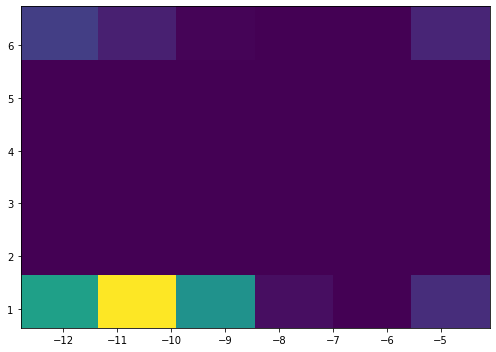

In [83]:
detetct_obstruction(site2)

(False, {}, <matplotlib.collections.QuadMesh at 0x7fcf510ba710>)

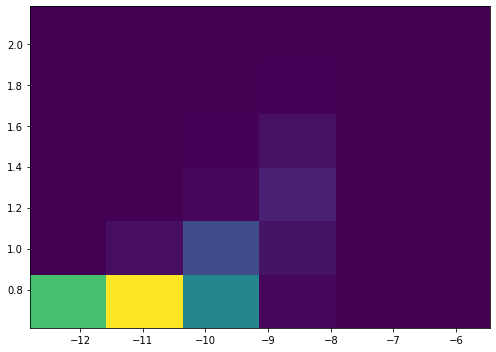

In [85]:
detetct_obstruction(site1)

### Isolating the main cluster, removing outer lobes and outliers

In [170]:
def vert_good(verts):
    min_pt = np.min(verts, axis = 0)
    max_pt = np.max(verts, axis = 0)
    m = (max_pt[1]- min_pt[1])/(max_pt[0]- min_pt[0])
    b = min_pt[1] - m*min_pt[0]
    new_verts = []
    for vert in verts:
        y1 = m*vert[0] + b
        if y1 - vert[1] >= 0:
            new_verts.append(vert)
    return new_verts

def density_filter(df_down, pct):
    df_down = df_down.copy()
    
    x1 = np.log(-1*df_down['mean diff']*3.28084)
    x2 = df_down['Value']*3.28084
    x_delta = np.max(x1) - np.min(x1)
    y_delta = np.max(x2) - np.min(x2)
    ratio = y_delta / x_delta
    X = np.array((ratio*x1,x2)).T # renormalize data for better DBSCAN clustering
    
    # clustering
    min_samples = pct*len(df_down) # the min number of samples in a cluster is based on a % of total data in set
    db = DBSCAN(eps=0.05, min_samples=min_samples).fit(X) # eps is an avg best value taken from ~30 sites
    labels, counts = np.unique(db.labels_, return_counts=True)
    df_down['labels'] = db.labels_
    big = df_down[df_down['labels'] != -1] # this is the set of all points not marked as outliers
    
    # finding the cluster shape
    points = np.array((-1*big['mean diff'], big['Value'])).T
    hull = ConvexHull(points) # finds the boundary of the cluster
    verts =points[hull.vertices]
    flashy_threshold = max(verts[:,1]) # finds the top of the cluster y threshold
    baseline = min(verts[:,1]) # finds the bottom of the cluster y threshold
    new_verts = vert_good(verts)
    bottom_line = np.sort(np.array(vert_good(verts)), axis=0) # traces the bottom-right edge of the cluster
    
    drop = df_down[df_down['labels'] == -1] # points that are marked outliers
    df_down['keep'] = df_down['labels'].where(df_down['labels'] < 0, other=1)

    return df_down, drop


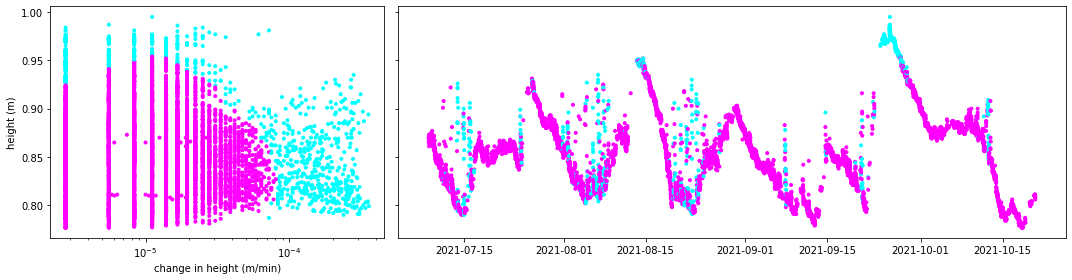

In [178]:
df, drop = density_filter(site4, pct=0.015)

fig, ax = plt.subplots(ncols=2, figsize = (15, 4), sharey='row', gridspec_kw={'width_ratios': [1, 2]})
ax[0].scatter(-1*df['mean diff'], df['Value'], marker='.', c=df['keep'], cmap='cool')
ax[0].set_xscale('log')
ax[1].scatter(df.index, df['Value'], marker = '.', c=df['keep'], cmap='cool')
ax[0].set_ylabel('height (m)')
ax[0].set_xlabel('change in height (m/min)')
plt.tight_layout()

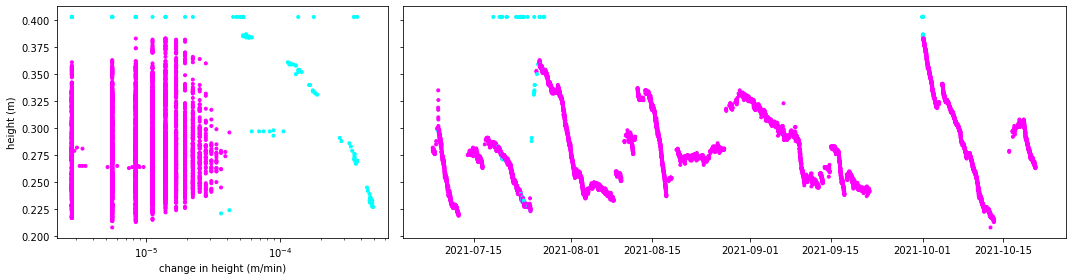

In [181]:
df, drop = density_filter(site5, pct=0.004)

fig, ax = plt.subplots(ncols=2, figsize = (15, 4), sharey='row', gridspec_kw={'width_ratios': [1, 2]})
ax[0].scatter(-1*df['mean diff'], df['Value'], marker='.', c=df['keep'], cmap='cool')
ax[0].set_xscale('log')
ax[1].scatter(df.index, df['Value'], marker = '.', c=df['keep'], cmap='cool')
ax[0].set_ylabel('height (m)')
ax[0].set_xlabel('change in height (m/min)')
plt.tight_layout()